In [1]:
import habitat
import habitat.gym
import os
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import (
    MeasurementConfig,
    ThirdRGBSensorConfig,
)

import matplotlib.pyplot as plt
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import clip
import numpy as np
import torch

os.chdir('/srv/flash1/pputta7/projects/lm-nav')
# Quiet the Habitat simulator logging
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"

In [2]:
sam = build_sam(checkpoint="models/sam_vit_h_4b8939.pth")
sam = sam.to('cuda')
mask_generator = SamAutomaticMaskGenerator(sam)

In [2]:
env = habitat.Env(config=habitat.get_config("config/imagenav_hm3d.yaml"))
observations = env.reset()  # noqa: F841

2023-08-30 00:34:11,152 Initializing dataset PointNav-v1
2023-08-30 00:34:11,436 initializing sim Sim-v0
2023-08-30 00:34:13,036 Initializing task Nav-v0


In [46]:
import groundingdino.datasets.transforms as T

def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

def load_image(img: str):
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_source = img.convert("RGB")
    image = np.asarray(image_source)
    image_transformed, _ = transform(image_source, None)
    return image, image_transformed

In [45]:
observations = env.step({'action': 'move_forward', 'action_args': None})

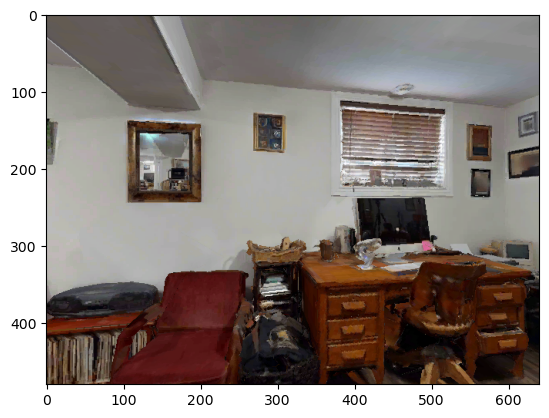

In [46]:
plt.imshow(observations['rgb'])

In [5]:
img = cv2.cvtColor(observations['rgb'], cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(img)

In [6]:
# Cut out all masks
image = Image.fromarray(img)
cropped_boxes = []

for mask in masks:
    #cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))
    cropped_boxes.append(image.crop(convert_box_xywh_to_xyxy(mask["bbox"])))

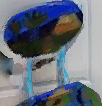

In [7]:
cropped_boxes[27]

In [43]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 177MiB/s]


In [15]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model = model.to('cuda')

In [19]:
captions = []
for image in [Image.fromarray(observations['rgb'])]:
    inputs = processor(images=image, return_tensors="pt").to('cuda')
    pixel_values = inputs.pixel_values
    
    generated_ids = model.generate(pixel_values=pixel_values, max_length=150)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    captions.append(generated_caption)

final text_encoder_type: bert-base-uncased


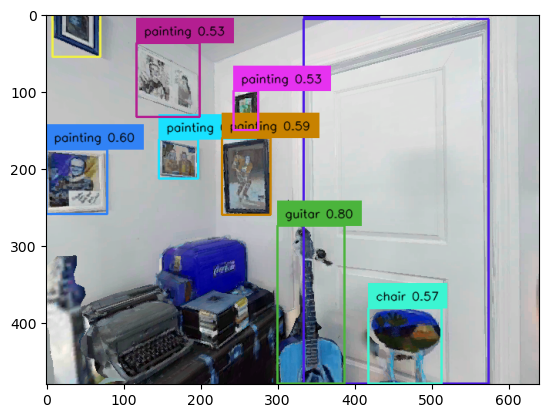

In [56]:
from groundingdino.util.inference import load_model, predict, annotate
import cv2

model = load_model("GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "models/groundingdino_swint_ogc.pth")
TEXT_PROMPT = """\
door . guitar . chair. painting . drawer .\
desk . computer
"""
BOX_THRESHOLD = 0.4
TEXT_TRESHOLD = 0.4

image_source, image = load_image(Image.fromarray(observations['rgb']))

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
plt.imshow(annotated_frame)

In [ ]:
observations = env.step({'action': 'turn_left', 'action_args': None})

[0.00011664628982543945, 0.00026297569274902344, 0.0003428459167480469, 0.00037670135498046875, 0.0004200935363769531, 0.0004267692565917969, 0.0004334449768066406, 0.00044035911560058594, 0.0004687309265136719, 0.00048351287841796875, 0.0004987716674804688, 0.0004987716674804688, 0.0005068778991699219, 0.0005230903625488281, 0.0005311965942382812, 0.0005393028259277344, 0.0005478858947753906, 0.0005741119384765625, 0.0005927085876464844, 0.0006208419799804688, 0.0006208419799804688, 0.0006308555603027344, 0.0006508827209472656, 0.0006928443908691406, 0.0007257461547851562, 0.0007371902465820312, 0.0007491111755371094, 0.0007491111755371094, 0.0007605552673339844, 0.0007848739624023438, 0.0008225440979003906, 0.000835418701171875, 0.000835418701171875, 0.0008754730224609375, 0.0008893013000488281, 0.0009036064147949219, 0.0009765625, 0.0009765625, 0.001056671142578125, 0.0011425018310546875, 0.0013561248779296875, 0.0013990402221679688, 0.0014209747314453125, 0.0014438629150390625, 0.0

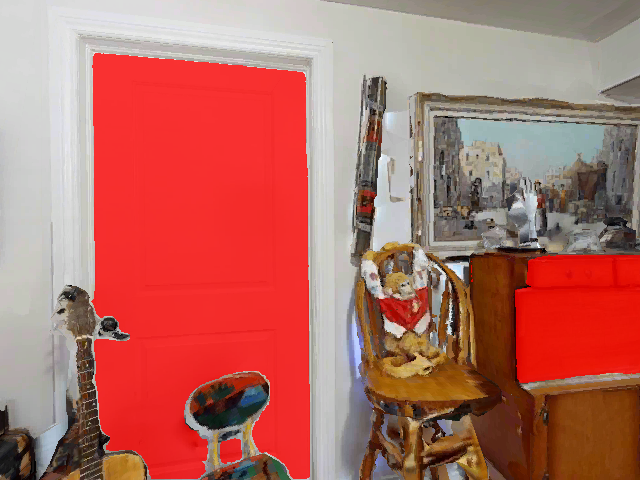

In [102]:
scores = retriev(cropped_boxes, "closed door")
print(sorted(scores.tolist()))
indices = get_indices_of_values_above_threshold(scores, 0.1)

segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
    segmentation_masks.append(segmentation_mask_image)

original_image = Image.fromarray(observations['rgb'])
overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
overlay_color = (255, 0, 0, 200)

draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
result_image

In [84]:
scores[27]

tensor(0.0179, device='cuda:0', dtype=torch.float16)

In [ ]:
p1 = "You are able to understand the visual content that the user provides.You are a navigational robot with egocentric vision that chooses the next action by choosing from {LEFT, RIGHT, FORWARD}. At every step, you receive a description of the current scene as seen from the camera. Your job is to navigate the environment through these actions to find the goal. For this task, the goal is to find a washing machine."
